# Navigating Algorithmic Fairness: Exploring and Addressing Bias through Latent Structures

## Datasets


To train our facial detection models, we require datasets containing positive examples (i.e., faces) and negative examples (i.e., non-face entities). The [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), a substantial collection exceeding 200,000 images featuring celebrity faces, serves as our positive training data. For negative training data, we turn to [ImageNet](http://www.image-net.org/), an extensive dataset encompassing a diverse array of images spanning numerous categories. Negative examples will be extracted from various non-human categories within ImageNet.

To assess the performance of our trained models and identify potential issues related to bias, fairness, and confidence, we will utilize an independent test dataset exclusively comprising face images.

In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
import os
import time
import h5py
import sys
import glob

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')       #chatGPT script to download data from dropbox

1263889489/1263889489 [==============================] - 12s 0us/step


In [3]:
### DataLoader ###

class DataBatchLoader(object):
    def __init__(self, dataset_path):
        print(f"Loading dataset from {dataset_path}")
        sys.stdout.flush()

        self.dataset = h5py.File(dataset_path, 'r')

        print("Transferring dataset to local memory...")
        sys.stdout.flush()
        self.data_images = self.dataset['images'][:]
        self.data_labels = self.dataset['labels'][:].astype(np.float32)
        self.data_shape = self.data_images.shape
        total_samples = self.data_shape[0]

        self.sample_indices = np.random.permutation(np.arange(total_samples))

        self.positive_indices = self.sample_indices[self.data_labels[self.sample_indices, 0] == 1.0]
        self.negative_indices = self.sample_indices[self.data_labels[self.sample_indices, 0] != 1.0]

    def total_train_samples(self):
        return len(self.sample_indices)

    def steps_per_epoch(self, batch_size, divisor=10):
        return self.total_train_samples() // divisor // batch_size

    def generate_batch(self, batch_size, faces_only=False, prob_positive=None, prob_negative=None, include_indices=False):
        if faces_only:
            chosen_indices = np.random.choice(self.positive_indices, size=batch_size, replace=False, p=prob_positive)
        else:
            pos_indices = np.random.choice(self.positive_indices, size=batch_size // 2, replace=False, p=prob_positive)
            neg_indices = np.random.choice(self.negative_indices, size=batch_size // 2, replace=False, p=prob_negative)
            chosen_indices = np.concatenate((pos_indices, neg_indices))

        sorted_indices = np.sort(chosen_indices)
        batch_images = (self.data_images[sorted_indices,:,:,::-1] / 255.0).astype(np.float32)
        batch_labels = self.data_labels[sorted_indices,...]
        return (batch_images, batch_labels, sorted_indices) if include_indices else (batch_images, batch_labels)

    def select_probable_faces(self, probabilities, count):
        sorted_indices = np.argsort(probabilities)[::-1]
        top_faces_indices = self.positive_indices[sorted_indices[:10*count:10]]
        return (self.data_images[top_faces_indices,...] / 255.0).astype(np.float32)

    def retrieve_all_faces(self):
        return self.data_images[self.positive_indices]

In [4]:
trainset_loader = DataBatchLoader(path_to_training_data)

Loading dataset from /root/.keras/datasets/train_face.h5
Transferring dataset to local memory...


In [5]:
number_of_training_examples = trainset_loader.total_train_samples()
(images, labels) = trainset_loader.generate_batch(100)

In [6]:
number_of_training_examples

109914

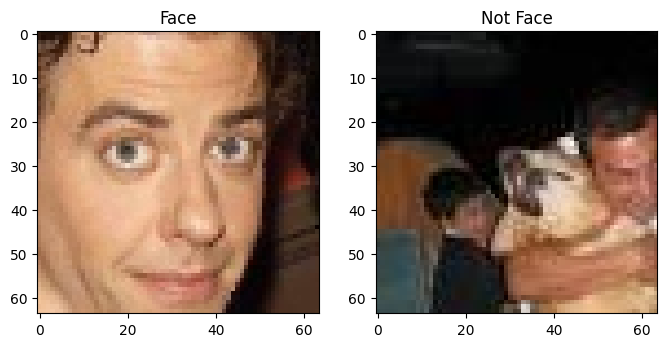

In [7]:
#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

### Examining the CelebA training dataset ###

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 3 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 1 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

## CNN for facial detection

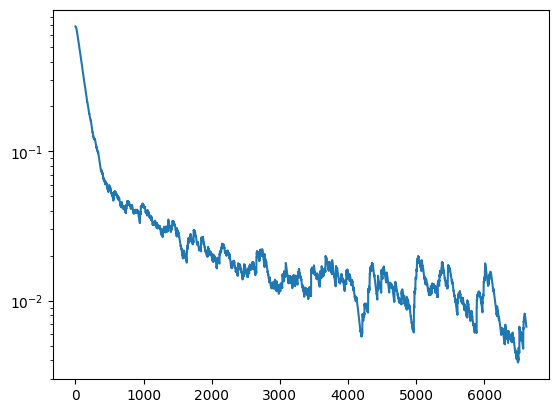

100%|██████████| 3434/3434 [00:42<00:00, 81.72it/s] 


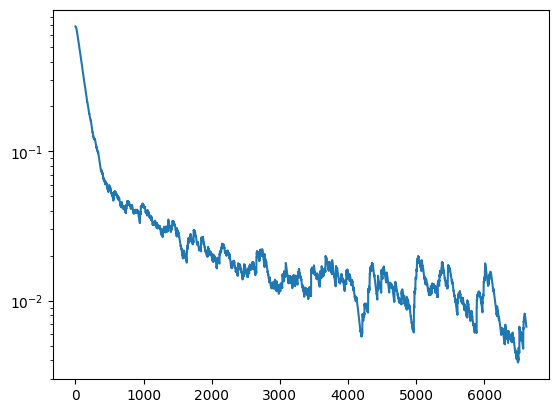

In [8]:
from IPython import display as ipythondisplay
from string import Formatter

### Define the CNN model ###

n_filters = 12  # Updated base number of convolutional filters

def create_custom_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

custom_classifier = create_custom_classifier()

# Loss History Class
class UpdatedLossHistory:
    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.loss = []
    def add(self, value):
        self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
    def retrieve(self):
        return self.loss

# Plotter Class
class EnhancedPlotter:
    def __init__(self, interval, xlabel='', ylabel='', scale=None):
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.interval = interval
        self.scale = scale
        self.start_time = time.time()

    def update_plot(self, data):
        if time.time() - self.start_time > self.interval:
            plt.cla()
            if self.scale is None:
                plt.plot(data)
            elif self.scale == 'semilogx':
                plt.semilogx(data)
            elif self.scale == 'semilogy':
                plt.semilogy(data)
            elif self.scale == 'loglog':
                plt.loglog(data)
            else:
                raise ValueError(f"Unknown scale: {self.scale}")

            plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            self.start_time = time.time()

### Train the standard CNN ###

# Training Hyperparameters and Logic
batch_size = 32
num_epochs = 2
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_record = UpdatedLossHistory(alpha=0.99)
plotter = EnhancedPlotter(interval=3, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def custom_train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = custom_classifier(images)            # feed the images into the model
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=predictions)       # Compute the loss
    # Backpropagation
    gradients = tape.gradient(loss, custom_classifier.trainable_variables)
    optimizer.apply_gradients(zip(gradients, custom_classifier.trainable_variables))
    return loss

# Training Loop
for epoch in range(num_epochs):
    for idx in tqdm(range(trainset_loader.total_train_samples() // batch_size)):       # Grab a batch of training data and propagate through the network
        imgs, lbls = trainset_loader.generate_batch(batch_size)
        loss_value = custom_train_step(imgs, lbls)
        # Record the loss and plot the evolution of the loss as a function of training
        loss_record.add(np.mean(loss_value.numpy()))
        plotter.update_plot(loss_record.retrieve())


In [10]:
### Evaluation of standard CNN ###
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = trainset_loader.generate_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(custom_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 1s 4ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9956


###  Diagnosing algorithmic bias

CNNs like the one we just built are pervasive as the standard solution for facial detection pipelines implemented throughout society. Despite their pervasiveness, these models -- including those implemented by top tech companies -- suffer from tremendous amounts of algorithmic bias. The seminal work of [Buolamwini and Gebru](https://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf) provided an approach and benchmark dataset to evaluate facial analysis algorithms, revealing startling accuracy discrepancies across skin tone and gender demographics.

In order to solve this problem and build fair and robust models, the first step is to determine the source of the problem. How can we determine the ***source*** of these accuracy discrepancies to identify and diagnose biases?

CNNs, much like the one we just constructed, have become a ubiquitous solution in facial detection pipelines deployed across various sectors. Despite their prevalence, these models, even those employed by leading tech companies, grapple with significant algorithmic biases. Buolamwini and Gebru's groundbreaking research introduced an approach and benchmark dataset for assessing facial analysis algorithms, exposing noteworthy accuracy disparities based on skin tone and gender.

To address this issue and cultivate fair and resilient models, the initial step involves pinpointing the root cause of these accuracy discrepancies. How can we discern the origin of these disparities to identify and diagnose biases?

One approach involves automatically revealing concealed biases. Discrepancies in the training data composition can inadvertently introduce algorithmic bias. For instance, CelebA, our training set, predominantly features faces of light-skinned females. Consequently, a classifier trained on CelebA may excel in recognizing and classifying faces with similar features, resulting in inherent bias.

Imagine if we could decipher the distribution of data features in an impartial, unsupervised manner, without relying on annotations. What insights could such an approach offer about latent biases within the data or areas where the model exhibits lower confidence in its predictions?

<!-- ### Naive approach

A naive approach -- and one that is being adopted by many companies and organizations -- would be to annotate different subclasses (i.e., light-skinned females, males with hats, etc.) within the training data, and then evaluate classifier performance with respect to these groups.

But this approach has two major disadvantages. First, it requires annotating massive amounts of data, which is not scalable. Second, it requires that we know what potential biases (e.g., race, gender, pose, occlusion, hats, glasses, etc.) to look for in the data. As a result, manual annotation may not capture all the different sources of bias and uncertainty that may exist. -->

### Automatically uncovering hidden biases

Imbalances in the training data can result in unwanted algorithmic bias. For example, the majority of faces in CelebA (our training set) are those of light-skinned females. As a result, a classifier trained on CelebA will be better suited at recognizing and classifying faces with features similar to these, and will thus be biased.

What if we actually ***learned*** the distribution of data features in an unbiased, unsupervised manner, without the need for any annotation? What could such an approach tell us about hidden biases that may exist in the data, or regions of the data in which the model is less confident in its predictions?

## 2.4 Variational autoencoder (VAE) for learning latent structure

The accuracy of facial detection classifiers can vary significantly across different demographics. Consider the dataset the CNN model was trained on, CelebA. If certain features, such as dark skin or hats, are *rare* in CelebA, the model may end up biased against these as a result of training with a biased dataset. That is to say, its classification accuracy will be worse on faces that have under-represented features, such as dark-skinned faces or faces with hats, relevative to faces with features well-represented in the training data! This is a problem.

Our goal is to train a model that **learns a representation of the underlying latent space** to the face training data. Such a learned representation will provide information on what features are under-represented or over-represented in the data. The key design requirement for our model is that it can learn an *encoding* of the latent features in the face data in an entirely *unsupervised* way, without any supervised annotation by us humans. To achieve this, we turn to variational autoencoders (VAEs).

![The concept of a VAE](https://upload.wikimedia.org/wikipedia/commons/4/4a/VAE_Basic.png)

As shown in the schematic above, VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. In the context of computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn.

Let's formalize two key aspects of the VAE model and define relevant functions for each.

### Understanding VAEs: loss function

In practice, how can we train a VAE? In learning the latent space, we constrain the means and standard deviations to approximately follow a unit Gaussian. Recall that these are learned parameters, and therefore must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss. What this means is that we'll have two terms in our VAE loss function:

1.  **Latent loss ($L_{KL}$)**: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence.
2.   **Reconstruction loss ($L_{x}{(x,\hat{x})}$)**: measures how accurately the reconstructed outputs match the input and is given by the $L^1$ norm of the input image and its reconstructed output.

The equation for the latent loss is provided by:

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

The equation for the reconstruction loss is provided by:

$$L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1$$

Thus for the VAE loss we have:

$$L_{VAE} = c\cdot L_{KL} + L_{x}{(x,\hat{x})}$$

where $c$ is a weighting coefficient used for regularization. Now we're ready to define our VAE loss function:

In [11]:
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):                         #https://www.frontiersin.org/articles/10.3389/fmats.2023.1233961/full
    latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
    vae_loss = kl_weight * latent_loss + reconstruction_loss
    return vae_loss

### Understanding VAEs: sampling and reparameterization

As you may recall from lecture, VAEs use a "reparameterization  trick" for sampling learned latent variables. Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample a noise value $\epsilon$ from a Gaussian distribution, and then scale it by the standard deviation and add back the mean to output the result as our sampled latent vector. Formalizing this for a latent variable $z$ where we sample $\epsilon \sim N(0,(I))$ we have:

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\Sigma}\right)}\circ \epsilon$$

where $\mu$ is the mean and $\Sigma$ is the covariance matrix. This is useful because it will let us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, **and** make our complete VAE network differentiable so that it can be trained via backpropagation.


In [12]:
def sampling(z_mean, z_logsigma):
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  return z

## Semi-supervised variational autoencoder (SS-VAE)

Now, we will use the general idea behind the VAE architecture to build a model to automatically uncover (potentially) unknown biases present within the training data, while simultaneously learning the facial detection task. This draws direct inspiration from [a research paper of MIT](https://dspace.mit.edu/bitstream/handle/1721.1/121101/AIES_2019_Algorithmic_Bias.pdf?sequence=1&isAllowed=y) proposing this as a general approach for automatic bias detetion and mitigation.


### Defining the SS-VAE loss function

This means we'll need to be a bit clever about the loss function for the SS-VAE. The form of the loss will depend on whether it's a face image or a non-face image that's being considered.

For **face images**, our loss function will have two components:

1.   **VAE loss ($L_{VAE}$)**: consists of the latent loss and the reconstruction loss.
2.   **Classification loss ($L_y(y,\hat{y})$)**: standard cross-entropy loss for a binary classification problem.

In contrast, for images of **non-faces**, our loss function is solely the classification loss.

We can write a single expression for the loss by defining an indicator variable ${I}_f$which reflects which training data are images of faces (${I}_f(y) = 1$ ) and which are images of non-faces (${I}_f(y) = 0$). Using this, we obtain:

$$L_{total} = L_y(y,\hat{y}) + {I}_f(y)\Big[L_{VAE}\Big]$$

Source - (https://arxiv.org/pdf/1406.5298.pdf) , ChatGPT


In [13]:
def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)

  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)

  # Use the training data labels to create variable face_indicator: indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  total_loss = tf.reduce_mean(
      classification_loss +
      face_indicator * vae_loss
  )

  return total_loss, classification_loss, vae_loss

## SS VAE  

![SS-VAE](https://drive.google.com/file/d/1LUTQloaYNhLr4B0uty8FYzJ42EE5xDw7/view?usp=sharing)

In [14]:
### Define the decoder portion of the SS-VAE ###

def face_decoder_network(n_filters=12):

  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [15]:
### Defining and creating the SS-VAE ###

class SS_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(SS_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = create_custom_classifier(num_encoder_dims)
    self.decoder = face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # Decode the latent space and output reconstruction
  def decode(self, z):
    #  using the decoder to output the reconstruction
    reconstruction = self.decoder(z)
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x):
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    z = sampling(z_mean, z_logsigma)

    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

ss_vae = SS_VAE(latent_dim=32)

In [16]:
def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()

Starting epoch 6/6


  0%|          | 0/3434 [00:00<?, ?it/s]

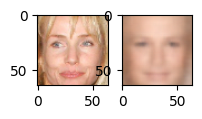

 14%|█▍        | 496/3434 [00:05<00:31, 92.28it/s]

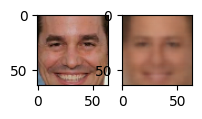

 29%|██▉       | 1000/3434 [00:12<00:26, 91.99it/s]

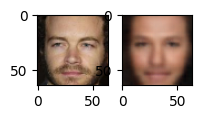

 44%|████▎     | 1497/3434 [00:18<00:21, 90.45it/s]

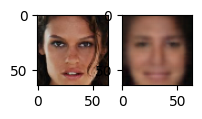

 58%|█████▊    | 1997/3434 [00:24<00:23, 60.88it/s]

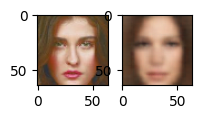

 73%|███████▎  | 2492/3434 [00:30<00:10, 91.86it/s]

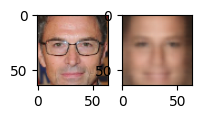

 87%|████████▋ | 2995/3434 [00:36<00:07, 62.36it/s]

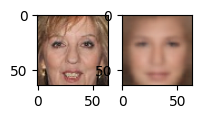

100%|██████████| 3434/3434 [00:42<00:00, 81.19it/s]


In [17]:
### Training the SS-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 32

# SS-VAE needs slightly more epochs to train since its more complex than
# the standard classifier so we use 6 instead of 2
num_epochs = 6

# instantiate a new SS-VAE model and optimizer
ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def ss_vae_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into ss_vae. Note that this is using the SS_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)

    #call the SS_VAE loss function to compute the loss
    loss, class_loss, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  #use the GradientTape.gradient method to compute the gradients.
  grads = tape.gradient(loss, ss_vae.trainable_variables)

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = trainset_loader.retrieve_all_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # get a batch of training data and compute the training step
  for j in tqdm(range(trainset_loader.total_train_samples() // batch_size)):
    # load a batch of data
    (x, y) = trainset_loader.generate_batch(batch_size)
    # loss optimization
    loss = ss_vae_train_step(x, y)

    # plot the progress every 200 steps
    if j % 500 == 0:
      plot_sample(x, y, ss_vae)

In [18]:
def create_grid_of_images(xs, size=(5,5)):
    grid = []
    counter = 0
    for i in range(size[0]):
        row = []
        for j in range(size[1]):
          row.append(xs[counter])
          counter += 1
        row = np.hstack(row)
        grid.append(row)
    grid = np.vstack(grid)
    return grid

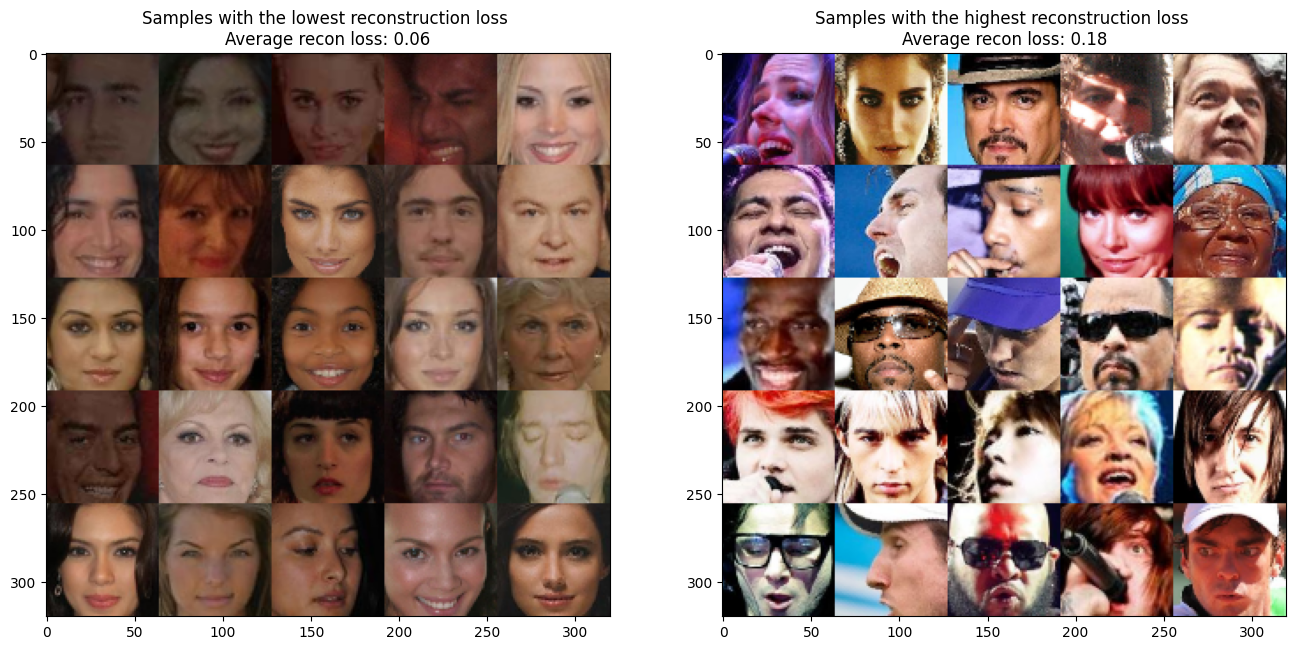

In [19]:
### Linking model performance to uncertainty and bias

# Load a random sample of 5000 faces from our dataset and compute the model performance on them
(x, y) = trainset_loader.generate_batch(5000, faces_only=True)
y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
loss, class_loss, vae_loss = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

# Sort the results by the vae loss scores
vae_loss = vae_loss.numpy()
ind = np.argsort(vae_loss, axis=None)

# Plot the 25 samples with the highest and lowest reconstruction losses
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(create_grid_of_images(x[ind[:25]]))
ax[0].set_title("Samples with the lowest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[:25]]):.2f}")

ax[1].imshow(create_grid_of_images(x[ind[-25:]]))
ax[1].set_title("Samples with the highest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[-25:]]):.2f}");

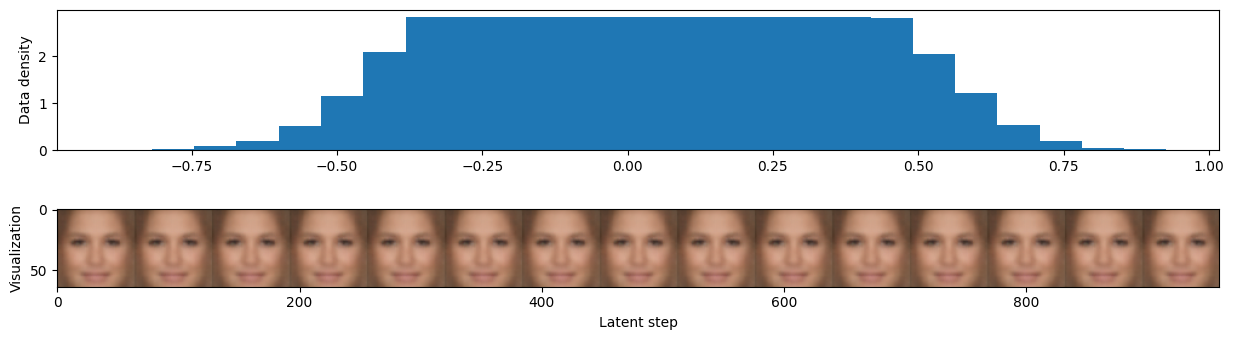

In [24]:
### Inspect different latent features

#@title Change the sliders to inspect different latent features! { run: "auto" }
idx_latent = 16 #@param {type:"slider", min:0, max:31, step:1}
num_steps = 15

# Extract all latent samples from the desired dimension
latent_samples = z_mean[:, idx_latent]

# Compute their density and plot
density, latent_bins = np.histogram(latent_samples, num_steps, density=True)
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].bar(latent_bins[1:], density)
ax[0].set_ylabel("Data density")

# Visualize reconstructions as we walk across the latent space
latent_steps = np.linspace(np.min(latent_samples), np.max(latent_samples), num_steps)
baseline_latent = tf.reduce_mean(z_mean, 0, keepdims=True)

recons = []
for step in latent_steps:
  # Adjust the latent vector according to our step
  latent = baseline_latent.numpy()
  latent[0, idx_latent] = step
  # Decode the reconstruction and store
  recons.append(ss_vae.decode(latent)[0])

# Visualize all of the reconstructions!
ax[1].imshow(create_grid_of_images(recons, (1, num_steps)))
ax[1].set_xlabel("Latent step")
ax[1].set_ylabel("Visualization");


Text(0, 0.5, 'Relative accuracy')

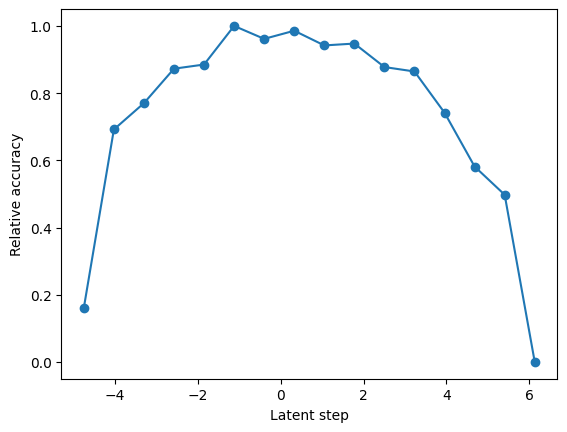

In [21]:
### Accuracy vs. density in latent space

# Loop through every latent dimension
avg_logit_per_bin = []
for idx_latent in range(latent_dim):
  latent_samples = z_mean[:, idx_latent]
  start = np.percentile(latent_samples, 5)
  end = np.percentile(latent_samples, 95)
  latent_steps = np.linspace(start, end, num_steps)

  # Find which samples fall in which bin of the latent dimension
  which_latent_bin = np.digitize(latent_samples, latent_steps)

  # For each latent bin, compute the accuracy (average logit score)
  avg_logit = []
  for j in range(0, num_steps+1):
    inds_in_bin = np.where(which_latent_bin == j)
    avg_logit.append(y_logit.numpy()[inds_in_bin].mean())

  avg_logit_per_bin.append(avg_logit)

# Average the results across all latent dimensions and all samples
accuracy_per_latent = np.mean(avg_logit_per_bin, 0)
accuracy_per_latent = (accuracy_per_latent - accuracy_per_latent.min()) / np.ptp(accuracy_per_latent)

# Plot the results
plt.plot(np.linspace(np.min(z_mean), np.max(z_mean), num_steps+1), accuracy_per_latent,'-o')
plt.xlabel("Latent step")
plt.ylabel("Relative accuracy")